In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-ct/demos/demo2.png
/kaggle/input/brain-ct/demos/demo3.png
/kaggle/input/brain-ct/demos/demo.jpg
/kaggle/input/brain-ct/demos/demo4.png
/kaggle/input/brain-ct/brain_CT_sinograms/56 (32).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/101 (24).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/116 (16).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/56 (2).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/106 (10).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/64 (1).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/96 (1) - Copy - Copy.jpg
/kaggle/input/brain-ct/brain_CT_sinograms/61 (22).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/98 (29) - Copy - Copy.jpg
/kaggle/input/brain-ct/brain_CT_sinograms/55 (32).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/50 (7).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/64 (17).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/126 (28).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/120 (23).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/108 (25).jpg
/kagg

In [1]:
import tensorflow as tf
import os
import numpy as np
import time
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2025-06-23 19:57:08.179953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750708628.573707      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750708628.691841      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Paths
input_dir = '/kaggle/input/brainctsinograms'
output_dir = '/kaggle/input/brain-ct/brain_CT'

# Get sorted file names (to ensure matching)
input_files = sorted(os.listdir(input_dir))
output_files = sorted(os.listdir(output_dir))


In [3]:
# Initialize lists
x_data = []
y_data = []

# Load images
for in_file, out_file in zip(input_files, output_files):
    # Load grayscale image and resize to (256, 256)
    input_img = load_img(os.path.join(input_dir, in_file), color_mode='grayscale', target_size=(363,256))
    output_img = load_img(os.path.join(output_dir, out_file), color_mode='grayscale', target_size=(256, 256))
    
    # Convert to array and normalize to [0, 1]
    x = img_to_array(input_img) / 255.0
    y = img_to_array(output_img) / 255.0

    x_data.append(x)
    y_data.append(y)

# Convert to NumPy arrays
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)

print("Input shape:", x_data.shape)   # (125, 256, 256, 1)
print("Output shape:", y_data.shape)  # (125, 256, 256, 1)

Input shape: (125, 363, 256, 1)
Output shape: (125, 256, 256, 1)


In [4]:
x_train = x_data[:100]
x_test = x_data[100:]
y_train = y_data[:100]
y_test = y_data[100:]

In [5]:
print(x_train.shape)
print(y_train.shape)

(100, 363, 256, 1)
(100, 256, 256, 1)


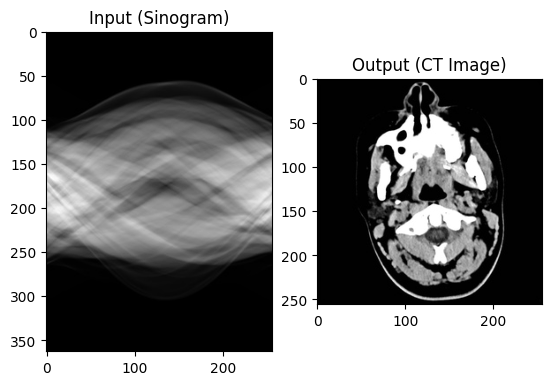

In [6]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(x_data[0].squeeze(), cmap='gray')
plt.title('Input (Sinogram)')

plt.subplot(1, 2, 2)
plt.imshow(y_data[0].squeeze(), cmap='gray')
plt.title('Output (CT Image)')
plt.show()

# Model

In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, Input, UpSampling2D, Resizing


def build_automap(input_shape=(363, 256, 1), downscale_by=4):
    inputs = Input(shape=input_shape)

    # Step 1: Downsample
    down_x = input_shape[0] // downscale_by
    down_y = input_shape[1] // downscale_by
    x = Resizing(down_x, down_y)(inputs)

    # Step 2: Flatten + Dense layers (more here!)
    x = Flatten()(x)
    x = Dense(4 * 64 * 64, activation='tanh')(x)      # Heavy Dense layer
    x = Dense(2 * 64 * 64, activation='tanh')(x)      # Optional: make this deeper if needed
    x = Dense(2 * 64 * 64, activation='tanh')(x)
    x = Dense(64 * 64, activation='tanh')(x)
    x = Dense(64 * 64, activation='tanh')(x)

    # Step 3: Reshape to feature map
    x = Reshape((64, 64, 1))(x)

    # Step 4: (Only one light deconvolution layer)
    x = UpSampling2D(size=(4, 4))(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid')(x)

    # Step 5 (optional): Resize output to match input height exactly (e.g., 363x256)
    x = Resizing(256, 256)(x)

    return models.Model(inputs, x)



In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
model = build_automap()
model.compile(optimizer=Adam(learning_rate=1e-4), loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

I0000 00:00:1750708654.519461      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750708654.520145      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 363, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 90, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5760)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16384)               │      94,388,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8192)                │     134,225,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8192)                │      67,117,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │      33,558,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 256, 256, 1)         │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_1 (Resizing)                │ (None, 256, 256, 1)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 346,071,050 (1.29 GB)

 Trainable params: 346,071,050 (1.29 GB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Training
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=4,
    epochs=300,
    verbose=1
)

Epoch 1/300


I0000 00:00:1750708680.709742      83 service.cc:148] XLA service 0x79cda400bd20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750708680.711312      83 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750708680.711330      83 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750708681.106597      83 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/25 ━━━━━━━━━━━━━━━━━━━━ 3:17 8s/step - loss: 0.2063 - mean_absolute_error: 0.4260

I0000 00:00:1750708685.422276      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - loss: 0.1456 - mean_absolute_error: 0.3534 - val_loss: 0.1156 - val_mean_absolute_error: 0.3173
Epoch 2/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.1164 - mean_absolute_error: 0.3162 - val_loss: 0.1127 - val_mean_absolute_error: 0.3128
Epoch 3/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.1149 - mean_absolute_error: 0.3138 - val_loss: 0.1108 - val_mean_absolute_error: 0.3095
Epoch 4/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.1126 - mean_absolute_error: 0.3091 - val_loss: 0.1097 - val_mean_absolute_error: 0.3074
Epoch 5/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.1107 - mean_absolute_error: 0.3073 - val_loss: 0.1077 - val_mean_absolute_error: 0.3041
Epoch 6/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.1095 - mean_absolute_error: 0.3045 - val_loss: 0.1056 - val_mean_absolute_error: 0.3009
Epoch 7/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.1082 - mean_absolute_error: 0.3009 - val_loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


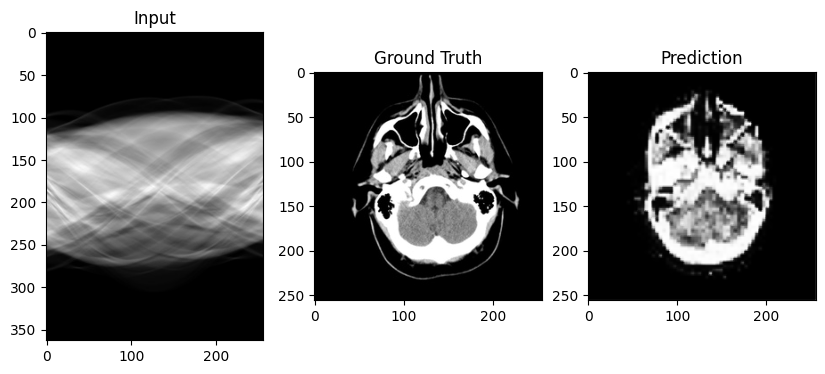

In [25]:
import matplotlib.pyplot as plt

i = 2  # index of sample
pred = model.predict(x_test[i:i+1])[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(x_test[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(y_test[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(pred.squeeze(), cmap='gray')
plt.show()


## Evaluate

In [16]:
import tensorflow as tf
import numpy as np

total_psnr = 0.0
total_ssim = 0.0
n = len(x_test)

for i in range(n):
    pred = model.predict(x_test[i:i+1], verbose=0)  # shape: (1, 256, 256, 1)
    gt = y_test[i:i+1]

    # Compute PSNR and SSIM
    psnr_val = tf.image.psnr(gt, pred, max_val=1.0).numpy()[0]
    ssim_val = tf.image.ssim(gt, pred, max_val=1.0).numpy()[0]

    total_psnr += psnr_val
    total_ssim += ssim_val

# Average metrics
avg_psnr = total_psnr / n
avg_ssim = total_ssim / n

print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")


Average PSNR: 12.99 dB
Average SSIM: 0.1986
